Introduction text
https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/
    

In [36]:
# libraries to import
import numpy as np
import matplotlib.pyplot as plt

In [201]:
# useful functions
def bar_plot(x_values, y_values, x_label="", y_label="", title=""):

    # Create bar plot
    plt.bar(x_values, y_values)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Show the plot
    plt.show()

def line_plot(y_values, x_values=None, x_label="", y_label="", title=""):
    
    # If x_values is not specified, use range of length of y_values
    if x_values is None:
        x_values = range(len(y_values))
    
    # Create line plot
    plt.plot(x_values, y_values)
    
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    # Show the plot
    plt.show()
    
def multiple_lines_plot(x_values, y_values_list, labels=[], x_label="", y_label="", title=""):

    # Create multiple lines plot
    for y_values, l in zip(y_values_list, labels):
        plt.plot(x_values, y_values, label='l')
        plt.legend(labels)

        
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Show the plot
    plt.show()
    
def sub_optimal_arm_chosen_plot(p, actions):
    optimal_arm = np.argmax(p)
    sub_optimal_arm_chosen = np.cumsum((actions != optimal_arm).astype(int))

    line_plot(y_values=sub_optimal_arm_chosen, x_label="Time", y_label="Total nb of times sub-optimal arm was chosen", title="# times sub-optimal arm was chosen")
    
def money_stats(initial_money, price_per_play, n_trials, reward, rewards):

    money_invested = n_trials * price_per_play
    money_gained = np.sum(rewards) * reward

    money_diff = money_gained - money_invested
    money_left = initial_money + money_diff

    print("Money initially : " + str(initial_money))
    print("Money invested : " + str(money_invested))
    print("Money gained : " + str(money_gained))
    print("Money difference : " + str(money_diff))
    print("Money left : " + str(money_left))

def money_plot(rewards, price_per_play):
    diff_per_play = np.array(rewards).reshape((len(rewards), 1)) - np.ones((len(rewards), 1)) * price_per_play
    line_plot(y_values=np.cumsum(diff_per_play), x_label="Time", y_label="Money difference", title="Money gain/loss over time")

# def money_plot_arm_changes(rewards, price_per_play, n_rounds, explore_per_arm, eliminations):
#     diff_per_play = np.array(rewards).reshape((len(rewards), 1)) - np.ones((len(rewards), 1)) * price_per_play
    
#     # Create line plot
#     plt.plot(range(len(y_values)), np.cumsum(diff_per_play))
    
#     vertical_lines = [eliminations[1]]
#     for elimination in eliminations:
#         plt.text(elimination[1] + 0.1, 0.8, '', color='r')
#         plt.text(4.1, 0.8, 'Line 2', color='r')
#         plt.text(6.1, 0.8, 'Line 3', color='r')
        
#     plt.vlines(vertical_lines, linestyle="--", colors='r')
    
#     # Add labels and title
#     plt.xlabel("Time")
#     plt.ylabel("Money difference")
#     plt.title("Money gain/loss over time")
    
#     # Show the plot
#     plt.show()
    
    
# Define the regret function
# actions is a list
def regret(actions, p):
    actions_array = actions.reshape(len(actions), 1).astype(int)
    return np.cumsum(np.max(p) - p[actions_array])

def plot_estimate_interval(n_arms, wins, losses, c):
    # Calculate upper and lower confidence bounds for each arm
    p = np.zeros(n_arms)
    lower_bounds = np.zeros(n_arms)
    upper_bounds = np.zeros(n_arms)
    for i in range(n_arms):
        if wins[i] + losses[i] > 0:
            p[i] = wins[i] / (wins[i] + losses[i])
            lower_bounds[i] = p[i] - c / np.sqrt(wins[i] + losses[i])
            upper_bounds[i] = p[i] + c / np.sqrt(wins[i] + losses[i])
        else:
            p[i] = 0
            lower_bounds[i] = 0
            upper_bounds[i] = 0
    
    # Plot bar plot with estimate interval
    x = np.arange(n_arms)
    fig, ax = plt.subplots()
    ax.bar(x, p, align='center', alpha=0.5)
    ax.vlines(x, lower_bounds, upper_bounds, colors='r', linewidth=2)
    ax.set_xlabel('Arm')
    ax.set_ylabel('Probability Estimate')
    ax.set_title('Estimate Interval')
    plt.show()

In [171]:
# Total number of arms
n_arms = 6

# probabilities
true_probs = np.random.rand(n_arms)
highest_prob_arm = np.argmax(true_probs)

print("The arm with the highest probability is at index : " + str(highest_prob_arm) + " \nits probability is : " + str(true_probs[highest_prob_arm]))


The arm with the highest probability is at index : 1 
its probability is : 0.8149347958409057


In [172]:
initial_money = 5000
price_per_play = 0.5
reward = 1
loss = 0

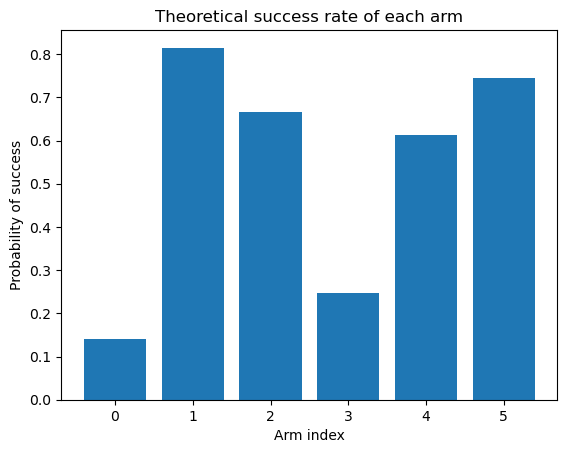

In [173]:
bar_plot(x_values = range(len(true_probs)), y_values = true_probs, x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm")

# Strategy 1 : Explore then exploit

For this, we explore by playing a 100 times each arm, then depending on which one got us the most wins, we decide to commit to it.

In [174]:
# variables to set
n_steps = 10000

def explore_then_exploit_naive(n_steps, n_arms, explore_fraction, p):
    if n_steps * price_per_play > initial_money:
        raise Exception("Not enough money to play ! Decrease the number of trials")
        
    if explore_fraction > 1.0:
        raise Exception("Explore fraction shouldn't be more than 1 !")
    
    explore_per_arm = int(np.floor(n_steps * explore_fraction / n_arms))
    n_steps_explore = explore_per_arm * n_arms
    n_steps_exploit = n_steps - n_steps_explore
    
    # arm chosen and reward corresponding
    actions = np.zeros((1, n_steps))
    rewards = np.zeros((1, n_steps))
    
    results_all_arms_end_of_explore = np.zeros((n_arms, explore_per_arm))

    # explore
    for arm_index in range(n_arms):
        results_for_arm = np.random.choice([0, 1], size=(1, explore_per_arm), p=[1-float(p[arm_index]), float(p[arm_index])])
        results_all_arms_end_of_explore[arm_index, :] = results_for_arm
        rewards[0, explore_per_arm * arm_index:explore_per_arm * (1+arm_index)] = results_for_arm
        actions[0, explore_per_arm * arm_index:explore_per_arm * (1+arm_index)] = np.ones((1, explore_per_arm)) * arm_index
        
    end_of_explore_results = np.sum(results_all_arms_end_of_explore, axis=1)
    
    # exploit
    best_arm = np.argmax(end_of_explore_results)
    result_for_exploited_arm = np.random.choice([0, 1], size=(1, n_steps_exploit), p=[1-float(p[best_arm]), float(p[best_arm])])
    rewards[0, n_steps_explore:] = result_for_exploited_arm
    actions[0, n_steps_explore:] = np.ones((1, n_steps_exploit)) * best_arm
    
    # formatting
    rewards = rewards.ravel()
    actions = actions.ravel()

    return explore_per_arm, results_all_arms_end_of_explore, end_of_explore_results, actions, rewards

In [175]:
explore_per_arm, results_all_arms_end_of_explore, end_of_explore_results, actions, rewards = explore_then_exploit_naive(n_steps, n_arms, 0.3, p=true_probs)

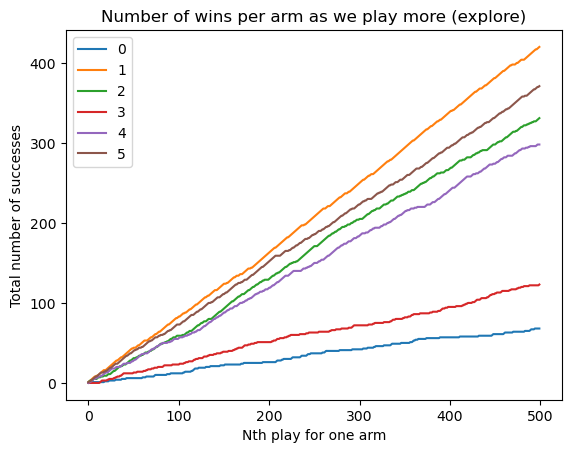

In [176]:
cum_sum_results_all_arms = np.cumsum(results_all_arms_end_of_explore, axis=1)
multiple_lines_plot(x_values=range(explore_per_arm), y_values_list=cum_sum_results_all_arms, labels=range(n_arms), x_label="Nth play for one arm", y_label="Total number of successes", title="Number of wins per arm as we play more (explore)")

In [177]:
end_of_explore_results

array([ 68., 420., 331., 123., 298., 371.])

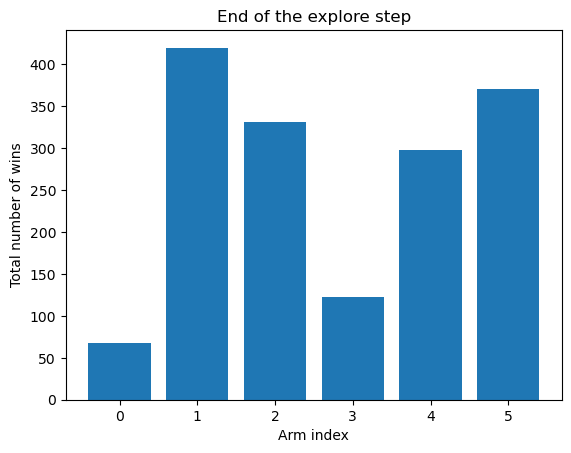

In [178]:
bar_plot(x_values=range(len(end_of_explore_results)), y_values=end_of_explore_results, x_label="Arm index", y_label="Total number of wins", title="End of the explore step")

In [179]:
index_with_most_wins = np.argmax(end_of_explore_results)
print("The arm that won the most at the end of exploration phase is : " + str(index_with_most_wins) + " with " + str(int(end_of_explore_results[index_with_most_wins])) + " wins.")

The arm that won the most at the end of exploration phase is : 1 with 420 wins.


## Results

Money initially : 5000
Money invested : 5000.0
Money gained : 7297.0
Money difference : 2297.0
Money left : 7297.0


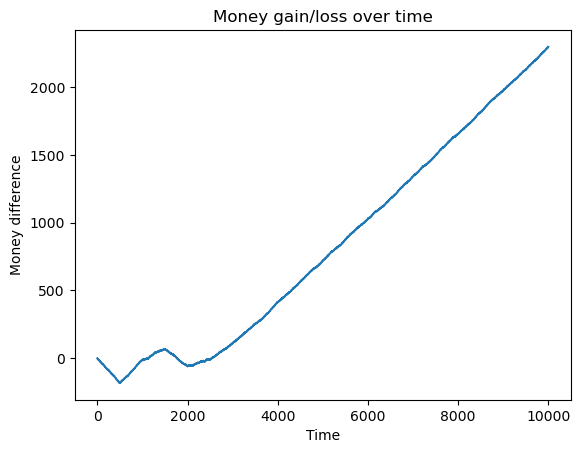

In [180]:
money_stats(initial_money, price_per_play, n_steps, reward, rewards)
money_plot(rewards.tolist(), price_per_play)

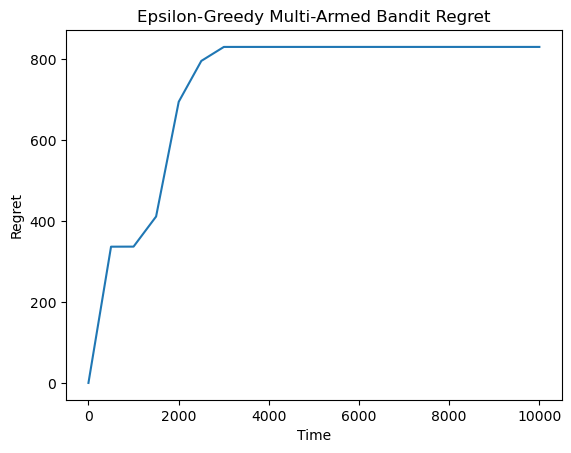

In [181]:
regret_vals = regret(actions, true_probs)
line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Epsilon-Greedy Multi-Armed Bandit Regret")

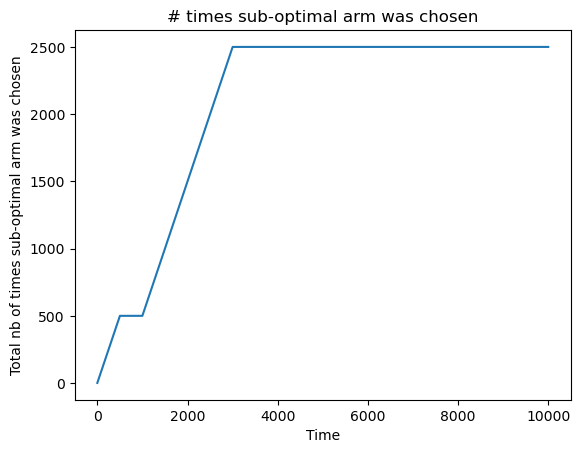

In [182]:
sub_optimal_arm_chosen_plot(p=true_probs, actions=actions)

# Strategy 2 : Explore then exploit - by elimination

In the previous strategy, we say decide initially how much we are going to play. To reduce the cost of exploring, we can enhance this strategy by eliminating the worst arm after a given number of plays so that we can avoid wasting money on the worst performing arm.

In [183]:
def total_explore_arm_pulls_for_elimination_algo(n_arms, n_rounds, round_steps_per_arm):
    total = 0
    for round_i in range(n_rounds):
        total = total + n_arms - round_i
    return total * round_steps_per_arm

In [184]:
n_trials = 10000

print("Total number of trials : " + str(n_trials))
    
def explore_then_exploit_elimination(n_steps, n_arms, n_rounds, round_steps_per_arm, p):
    n_steps_explore = total_explore_arm_pulls_for_elimination_algo(n_arms, n_rounds, round_steps_per_arm) 
    n_steps_exploit = n_steps - n_steps_explore
    
    if n_steps * price_per_play > initial_money:
        raise Exception("Not enough money to play ! Decrease the number of trials")
        
    if n_rounds >= n_arms:
        raise Exception("Number of rounds should be strictly lesser than the number of arms")

    if n_steps < n_steps_explore:
        raise Exception("Increase number of trials, or decrease the number of rounds or the number of steps per arm for each round")
    
    end_of_explore_total = np.zeros((n_arms, 1))
    poor_performing_arms = []
    
    # contains (arm, step) for elimination history
    eliminations = []

    actions = np.zeros((1, n_steps))
    rewards = np.zeros((1, n_steps))

    results_all_arms_end_of_explore = np.zeros((n_arms, 0))
    results_all_arms = np.zeros((n_arms, 0))
    
    # stores the total nb of arms visited
    counter_arm = 0

    # explore
    for i in range(n_rounds):

        results_all_arms = np.zeros((n_arms, round_steps_per_arm))

        for arm_index in range(n_arms):
            # doesn't exist in the poor performing list
            if poor_performing_arms.count(arm_index) == 0:
                results_all_arms[arm_index, :] = np.random.choice([0, 1], size=(1, round_steps_per_arm), p=[1-float(p[arm_index]), float(p[arm_index])])
                
                actions[0, round_steps_per_arm * counter_arm:round_steps_per_arm * (1+counter_arm)] = np.ones((1, round_steps_per_arm)) * arm_index
                rewards[0, round_steps_per_arm * counter_arm:round_steps_per_arm * (1+counter_arm)] = results_all_arms[arm_index, :]
                counter_arm = counter_arm + 1
        
        end_of_round_results = np.sum(results_all_arms, axis=1).reshape((n_arms,1))
        end_of_explore_total = end_of_explore_total + end_of_round_results

        index_with_least_wins = np.argsort(end_of_explore_total, axis=0)[i]
        
        print("Round " + str(i) + ", The arm that won the least is : " + str(index_with_least_wins) + " with " + str(int(end_of_explore_total[index_with_least_wins])) + " wins.")
        poor_performing_arms.append(index_with_least_wins)
        eliminations.append((index_with_least_wins, round_steps_per_arm * counter_arm))

        results_all_arms_end_of_explore = np.concatenate((results_all_arms_end_of_explore, results_all_arms), axis=1)
        
        if i == n_rounds - 1:
            results_all_arms = np.concatenate((results_all_arms, results_all_arms_end_of_explore), axis=1)
            
        
    # exploit
    best_arm = np.argmax(end_of_explore_total)
    result_for_exploited_arm = np.random.choice([0, 1], size=(1, n_steps_exploit), p=[1-float(p[best_arm]), float(p[best_arm])])
    rewards[0, n_steps_explore:] = result_for_exploited_arm
    actions[0, n_steps_explore:] = np.ones((1, n_steps_exploit)) * best_arm
    
    # format
    actions = actions.ravel()
    rewards = rewards.ravel()

    # reshape
    return results_all_arms_end_of_explore, end_of_explore_total, results_all_arms, eliminations, actions, rewards

Total number of trials : 10000


In [185]:
results_all_arms_end_of_explore, end_of_explore_total, results_all_arms, eliminations, actions, rewards = explore_then_exploit_elimination(n_trials, n_arms, n_arms - 1, 200, p=true_probs)

Round 0, The arm that won the least is : [0] with 29 wins.
Round 1, The arm that won the least is : [3] with 107 wins.
Round 2, The arm that won the least is : [4] with 359 wins.
Round 3, The arm that won the least is : [2] with 539 wins.
Round 4, The arm that won the least is : [5] with 750 wins.


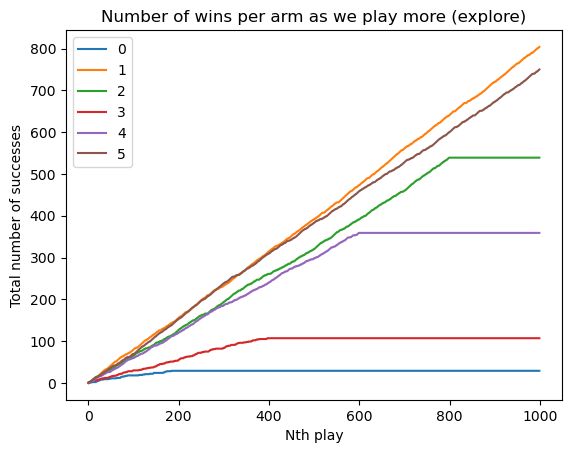

In [186]:
cum_sum_results_all_arms = np.cumsum(results_all_arms_end_of_explore, axis=1)

multiple_lines_plot(x_values=range(results_all_arms_end_of_explore.shape[1]), y_values_list=cum_sum_results_all_arms, labels=range(n_arms), x_label="Nth play", y_label="Total number of successes", title="Number of wins per arm as we play more (explore)")

In [187]:
end_of_explore_total

array([[ 29.],
       [804.],
       [539.],
       [107.],
       [359.],
       [750.]])

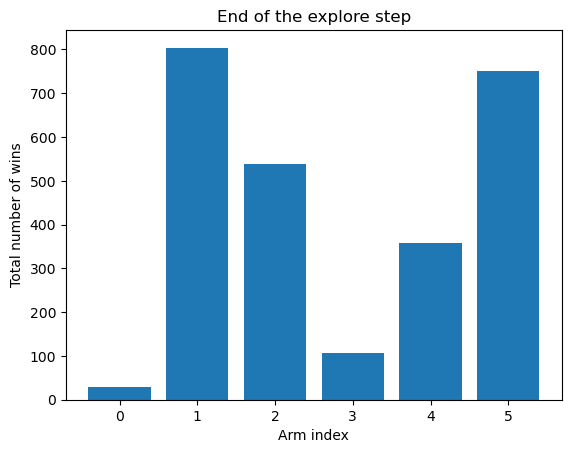

In [188]:
bar_plot(x_values=range(len(end_of_explore_total.ravel())), y_values=end_of_explore_total.ravel(), x_label="Arm index", y_label="Total number of wins", title="End of the explore step")

In [189]:
index_with_most_wins = np.argmax(end_of_explore_total)
print("The arm that won the most at the end of exploration phase is : " + str(index_with_most_wins) + " with " + str(int(end_of_explore_total[index_with_most_wins])) + " wins.")

The arm that won the most at the end of exploration phase is : 1 with 804 wins.


## Results

Money initially : 5000
Money invested : 5000.0
Money gained : 7515.0
Money difference : 2515.0
Money left : 7515.0


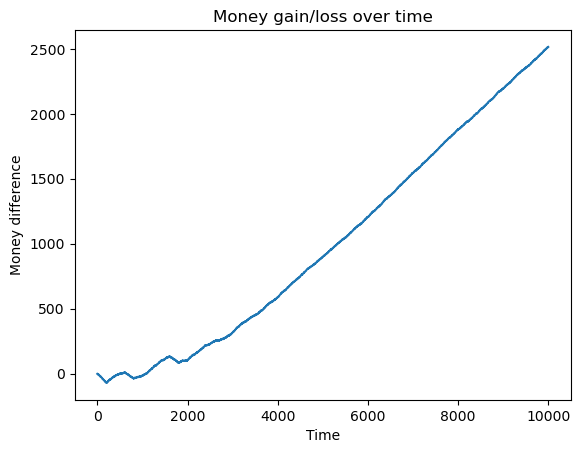

In [190]:
money_stats(initial_money, price_per_play, n_steps, reward, rewards)
money_plot(rewards.tolist(), price_per_play)

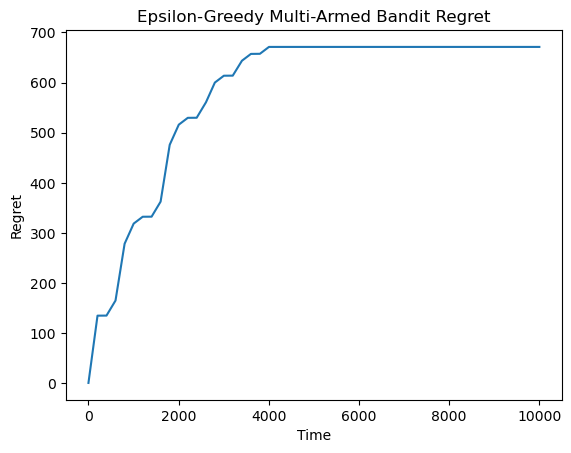

In [191]:
regret_vals = regret(actions, true_probs)
line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Epsilon-Greedy Multi-Armed Bandit Regret")

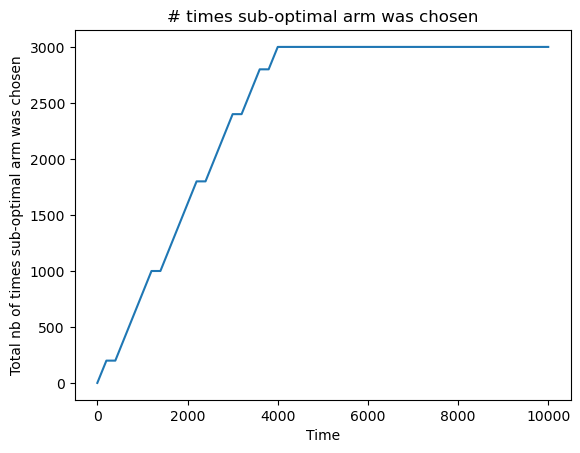

In [192]:
sub_optimal_arm_chosen_plot(p=true_probs, actions=actions)

In [193]:
# todo dash line to show when we switch arm
# money_plot_arm_changes(rewards, price_per_play, n_rounds, explore_per_arm, eliminations)

# Strategy 3 : Epsilon-Greedy Algorithm

In the previous strategy, we say decide initially how much we are going to play. This can become a problem in situations where we have limited resources. 
A strategy would be to assign weights to each arm and recalculate every time we try one.

The epsilon-greedy algorithm is a simple algorithm for exploring and exploiting a set of options or actions in a reinforcement learning problem or a multi-armed bandit problem. The algorithm works as follows:

1. Initialize a set of action-value estimates Q(a) for each action a.

2. For each time step t:

    a. With probability epsilon, select a random action.

    b. Otherwise, select the action with the highest action-value estimate.

    c. Take the selected action and observe the reward r.

    d. Update the action-value estimate Q(a) for the selected action using the observed reward r.

3. Repeat step 2 for a fixed number of time steps or until convergence.

In [194]:
n_trials = 10000
initial_money = 5000

# check we have enough money
if n_trials * price_per_play > initial_money:
    raise Exception("You don't have enough money initially !")

In [195]:
# Define the multi-armed bandit algorithm
def epsilon_greedy(epsilon, n_arms):
    Q = np.zeros(n_arms) # Action-value estimates
    N = np.zeros(n_arms) # Number of times each action is taken
    def policy(state):
        if np.random.rand() < epsilon:
            return np.random.choice(n_arms)
        else:
            return np.argmax(Q)
    def update(state, action, reward):
        N[action] += 1
        Q[action] += (1 / N[action]) * (reward - Q[action])
    return policy, update

def run_epsilon_greedy(n_trials, n_arms, epsilon, p):
    
    # check we have enough money
    if n_trials * price_per_play > initial_money:
        raise Exception("You don't have enough money initially !")
    
    # Run the multi-armed bandit algorithm
    policy, update = epsilon_greedy(epsilon, n_arms)

    actions = np.zeros((1, n_trials)) # arm picked
    rewards = np.zeros((1, n_trials)) # result of action 

    for t in range(n_trials):
        action = policy(None)
        reward = np.random.binomial(1, p[action])
        actions[0, t] = action
        rewards[0, t] = reward
        update(None, action, reward)
        
    return actions.ravel(), rewards.ravel()


In [196]:
actions, rewards = run_epsilon_greedy(n_trials, n_arms, epsilon=0.01, p=true_probs)

## Results

Money initially : 5000
Money invested : 5000.0
Money gained : 6999.0
Money difference : 1999.0
Money left : 6999.0


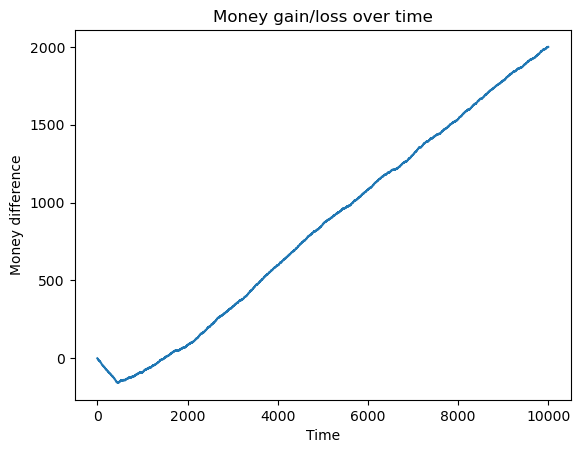

In [197]:
# Calculating money    
money_stats(initial_money, price_per_play, n_trials, reward, rewards)
money_plot(rewards, price_per_play)

In [198]:
# Compute the regret
regret_vals = regret(actions, true_probs)

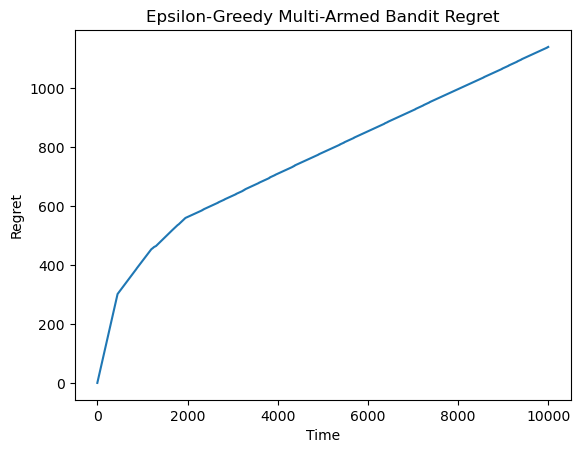

In [199]:
# Plot the regret
line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Epsilon-Greedy Multi-Armed Bandit Regret")

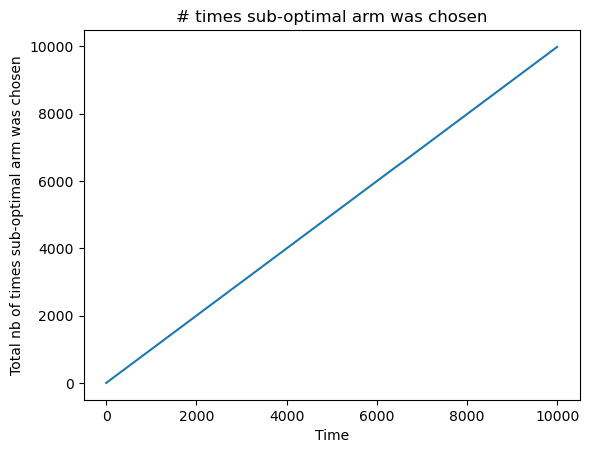

In [200]:
sub_optimal_arm_chosen_plot(p=true_probs, actions=actions)

# Strategy 4 : Explore then exploit

In [202]:
c = 0.9 # 0.8 is good
n_trials = 10000
initial_money = 5000

if n_trials * price_per_play > initial_money:
    raise Exception("Not enough money to play ! Decrease the number of trials")

In [242]:
def elimination_confidence_bound_algorithm(n_arms, n_steps, c, p):
    # Initialize variables
    wins = np.zeros(n_arms)
    losses = np.zeros(n_arms)
    upper_bounds = np.ones(n_arms) * float('inf')
    lower_bounds = np.ones(n_arms) * float('-inf')
    p_hat = np.zeros(n_arms)
    selected_arms = np.zeros(n_steps)
    rewards = np.zeros(n_steps)
    eliminated_arms = []
    
    counter = 0
    
    for step in range(n_steps):
        # Calculate upper confidence bounds for each arm
        for i in range(n_arms):
            if eliminated_arms.count(i) == 0:
                if wins[i] + losses[i] > 0:
                    p_hat[i] = wins[i] / (wins[i] + losses[i])
                    upper_bounds[i] = p_hat[i] + c / np.sqrt(wins[i] + losses[i])
                    lower_bounds[i] = p_hat[i] - c / np.sqrt(wins[i] + losses[i])
        
        for selected_arm in range(n_arms):

            if eliminated_arms.count(selected_arm) == 0:
                counter = counter + 1
                selected_arms[counter] = selected_arm

                # Simulate play for each arm and update wins and losses
                if np.random.rand() < p[selected_arm]:  # simulate win with probability p_i
                    wins[selected_arm] += 1
                    rewards[counter] = 1
                else:
                    losses[selected_arm] += 1
                    rewards[counter] = 0
                
            if(counter == n_steps-1): 
                return selected_arms, rewards, wins, losses
            
        # todo ask if taking highest upperbound is better ?
        highest_p_hat = np.argmax(p_hat)
        

        # Check if there is only one arm left
        if np.sum(upper_bounds != float('-inf')) >= 1:
            # Check to eliminate arm
            for i in range(n_arms):
                if eliminated_arms.count(i) == 0:
                    if upper_bounds[i] < lower_bounds[highest_p_hat]:    
                        print("eliminated arm : " + str(i) + ", at step : " + str(step))
                        eliminated_arms.append(i)
                                  
    # Return selected arms at each step
    return selected_arms, rewards, wins, losses

In [243]:
selected_arms, rewards, wins, losses = elimination_confidence_bound_algorithm(n_arms, n_trials, c, true_probs)

print(len(selected_arms))

eliminated arm : 3, at step : 6
eliminated arm : 0, at step : 10
eliminated arm : 2, at step : 41
eliminated arm : 4, at step : 48
eliminated arm : 5, at step : 300
10000


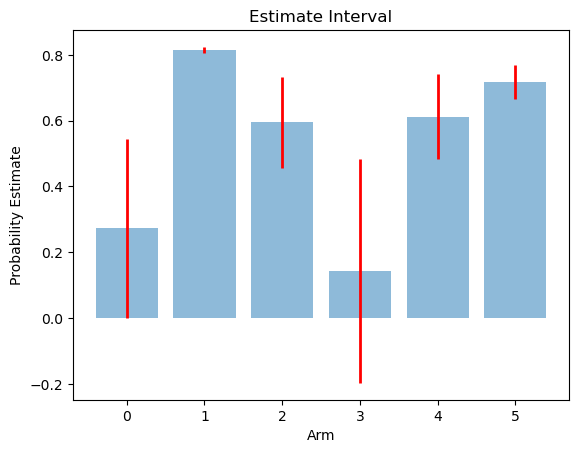

(10000,)
8092.0


In [244]:
# estimate interval at the end 
plot_estimate_interval(n_arms, wins, losses, c)

print(selected_arms.shape)
print(np.sum(wins))

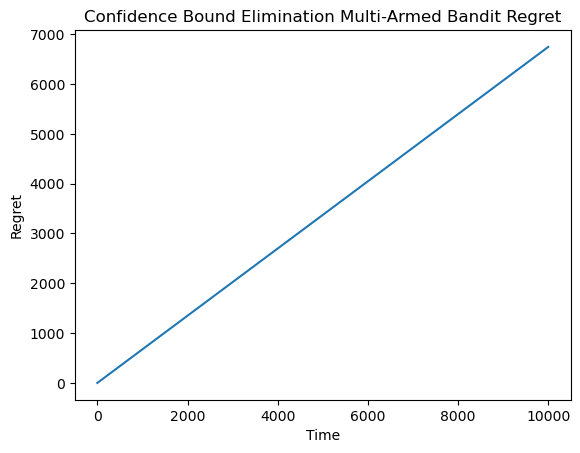

In [261]:
# Compute the regret
regret_vals = regret(selected_arms, true_probs)
# Plot the regret
# line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Confidence Bound Elimination Multi-Armed Bandit Regret")
line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Confidence Bound Elimination Multi-Armed Bandit Regret")

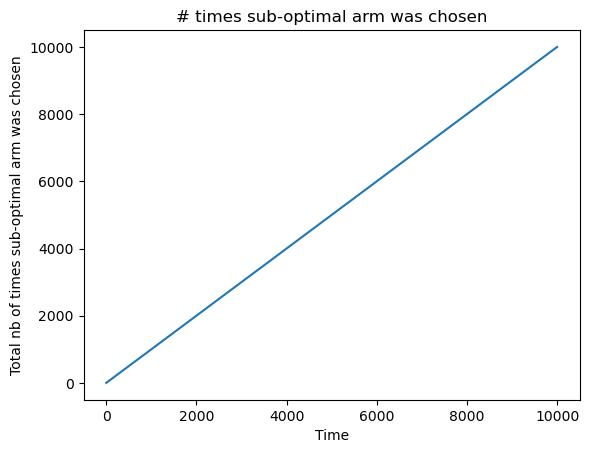

In [262]:
sub_optimal_arm_chosen_plot(p=true_probs, actions=selected_arms)

In [263]:
money_stats(initial_money, price_per_play, n_trials, reward, rewards)

Money initially : 5000
Money invested : 5000.0
Money gained : 1.0
Money difference : -4999.0
Money left : 1.0


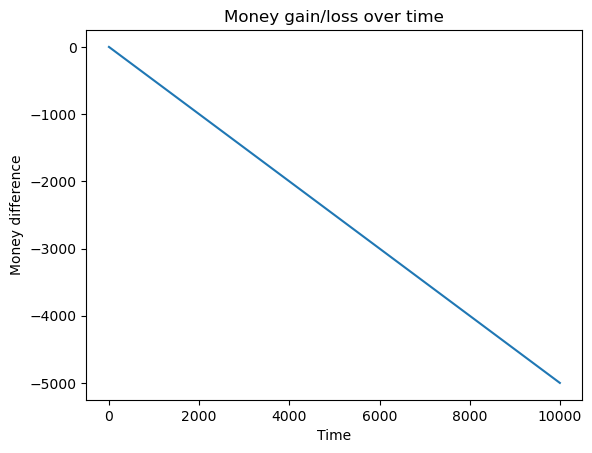

In [264]:
money_plot(rewards, price_per_play)

In [249]:
# variables
c = 0.9 # 0.8 is good
n_trials = 10000
initial_money = 5000

if n_trials * price_per_play > initial_money:
    raise Exception("Not enough money to play ! Decrease the number of trials")

In [255]:
def ucb_algorithm(n_arms, n_steps, c, p):
    # Initialize variables
    wins = np.zeros(n_arms)
    losses = np.zeros(n_arms)
    upper_bounds = np.ones(n_arms) * float('inf')
    lower_bounds = np.ones(n_arms) * float('-inf')
    selected_arms = np.zeros(n_steps)
    rewards = np.zeros(n_steps)
    
    counter = 0
    for step in range(n_steps):
        # Calculate upper confidence bounds for each arm
        for i in range(n_arms):
            if wins[i] + losses[i] > 0:
                p_i = wins[i] / (wins[i] + losses[i])
                upper_bounds[i] = p_i + c / np.sqrt(wins[i] + losses[i])
                lower_bounds[i] = p_i - c / np.sqrt(wins[i] + losses[i])
        
        # Select arm with highest upper confidence bound
        selected_arm = np.argmax(upper_bounds)
        selected_arms[counter] = selected_arm
        
        # Simulate play and update wins and losses
        if np.random.rand() < p[selected_arm]:  # simulate win with probability p_i
            wins[selected_arm] += 1
            rewards[counter] = 1
        else:
            losses[selected_arm] += 1
            rewards[counter] = 0   

    # Return selected arms at each step
    return selected_arms, rewards, wins, losses

In [256]:
selected_arms, rewards, wins, losses = ucb_algorithm(n_arms, n_trials, c, true_probs)

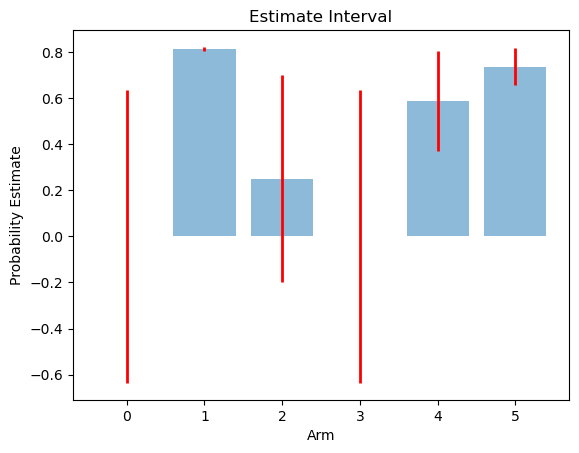

In [257]:
# estimate interval at the end 
plot_estimate_interval(n_arms, wins, losses, c)

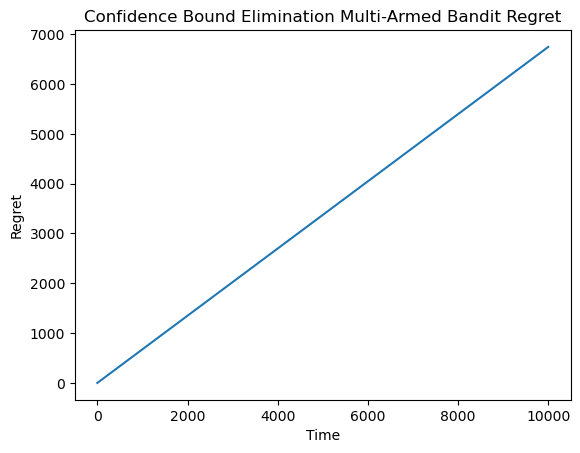

In [258]:
# Compute the regret
regret_vals = regret(selected_arms, true_probs)

# Plot the regret
line_plot(y_values=regret_vals, x_label="Time", y_label="Regret", title="Confidence Bound Elimination Multi-Armed Bandit Regret")

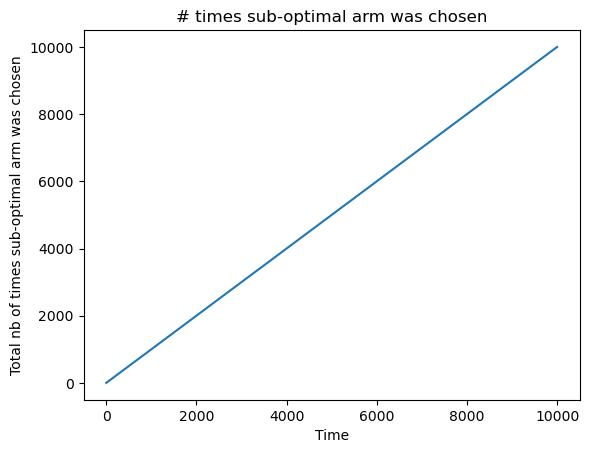

In [259]:
sub_optimal_arm_chosen_plot(p=true_probs, actions=selected_arms)

In [260]:
money_stats(initial_money, price_per_play, n_trials, reward, rewards)

Money initially : 5000
Money invested : 5000.0
Money gained : 1.0
Money difference : -4999.0
Money left : 1.0


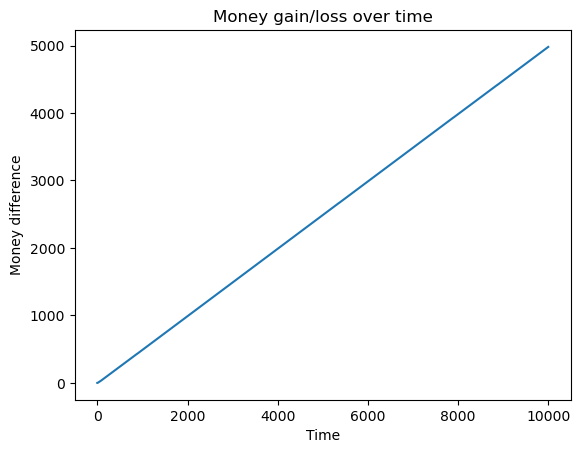

In [280]:
money_plot(rewards, price_per_play)

# Week 3